In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet

In [ ]:
df=pd.read_excel("output.xlsx")

In [ ]:
df=df[["Date","Total_Amount"]]

In [ ]:
df = df.groupby('Date')['Total_Amount'].sum().reset_index()

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Total_Amount'].quantile(0.25)
Q3 = df['Total_Amount'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define outliers based on 1.5*IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with boundary values
df['Total_Amount'] = df['Total_Amount'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print DataFrame after replacing outliers
print("DataFrame after replacing outliers:")
print(df)


DataFrame after replacing outliers:
          Date  Total_Amount
0   2023-03-01  1.104406e+06
1   2023-03-02  1.123873e+06
2   2023-03-03  1.097692e+06
3   2023-03-04  1.081359e+06
4   2023-03-05  1.153814e+06
..         ...           ...
361 2024-02-25  1.066046e+06
362 2024-02-26  1.115839e+06
363 2024-02-27  1.199350e+06
364 2024-02-28  1.151965e+06
365 2024-02-29  1.191365e+06

[366 rows x 2 columns]


In [6]:
df.count()

Date            366
Total_Amount    366
dtype: int64

In [7]:
def check_stationarity(df):
    result = adfuller(df['Total_Amount'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")
        return False
    return True

# Set index as Date
df.set_index('Date', inplace=True)

# Check if the data is stationary
is_stationary = check_stationarity(df)


ADF Statistic: -17.76827922949123
p-value: 3.315905296440118e-30
Critial Values:
   1%, -3.4483935212959844
Critial Values:
   5%, -2.8694912343676497
Critial Values:
   10%, -2.571005879151811
The series is stationary.


C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Total_Amount   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4565.383
Date:                Mon, 12 Aug 2024   AIC                           9136.766
Time:                        11:28:51   BIC                           9148.466
Sample:                    03-01-2023   HQIC                          9141.415
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2509      0.022     11.646      0.000       0.209       0.293
ma.L1         -0.7394      0.027    -27.382      0.000      -0.792      -0.686
sigma2      3.404e+09   2.16e-12   1.57e+21      0.0

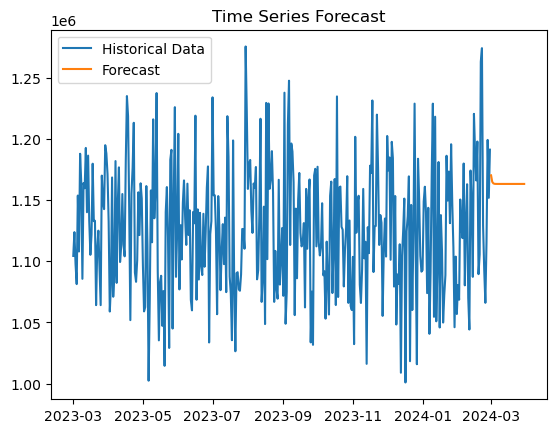

In [8]:
# Fit the ARIMA model 
model = ARIMA(df['Total_Amount'], order=(1, 1, 1))  # Assuming the first differencing made it stationary
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=30)  # Forecast next 10 steps
print(forecast)

# Plotting the forecast
plt.plot(df.index, df['Total_Amount'], label='Historical Data')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='D')[1:], forecast, label='Forecast')
plt.title('Time Series Forecast')
plt.legend()
plt.show()


In [9]:
# In above model forcasted values are constant 
# so we have to fine-tune parameter (p,d,q)
# we ploted ACF & PACF graph for finding p and q value

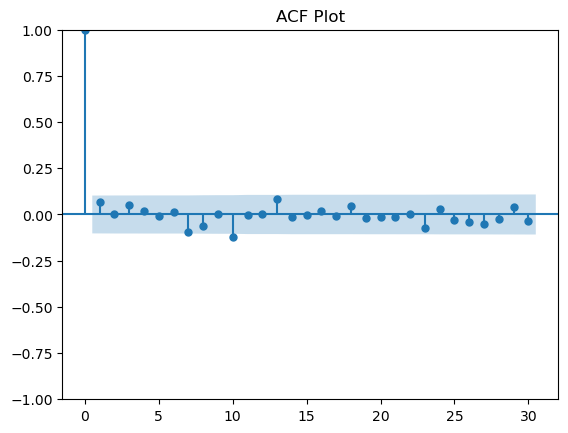

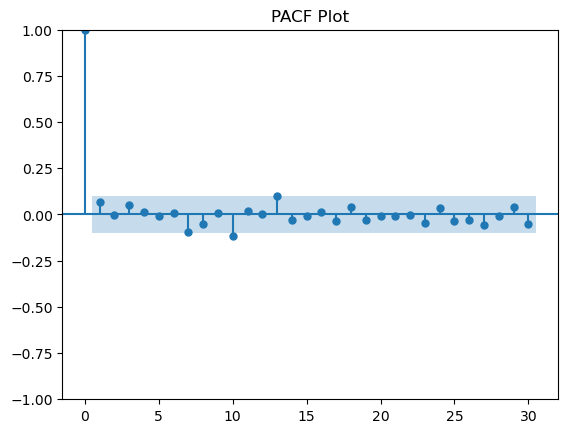

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF(q) and PACF(p)
plot_acf(df['Total_Amount'], lags=30)
plt.title('ACF Plot')
plt.show()

plot_pacf(df['Total_Amount'], lags=30)
plt.title('PACF Plot')
plt.show()


C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sanket\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 48375.821213365416
Mean Squared Error (MSE): 3579545561.4249926
Root Mean Squared Error (RMSE): 59829.303534513856
R^2 Score: -0.09446260591127276


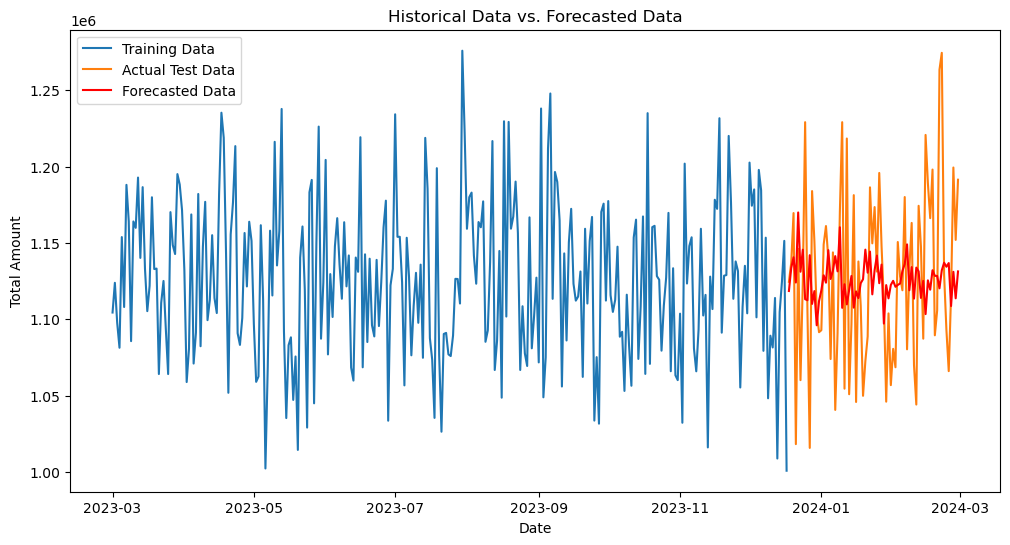

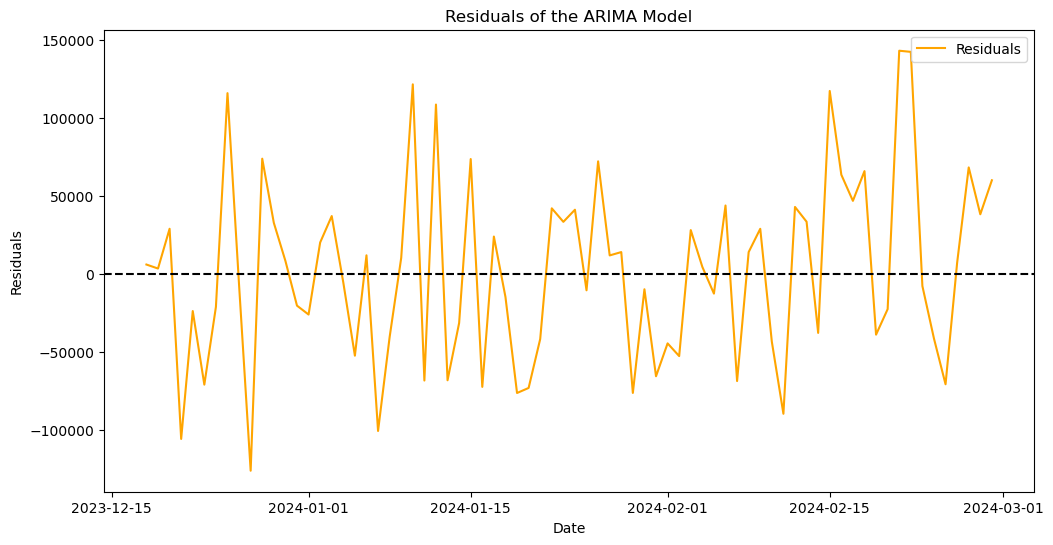

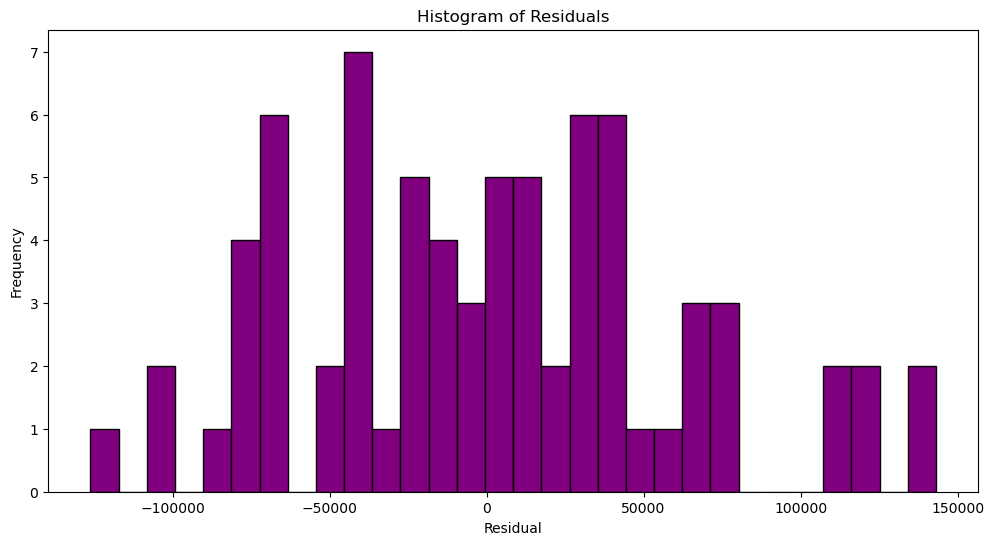

In [11]:
p, d, q = 10, 0, 10  # Example values, replace with your actual values

# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train['Total_Amount'], order=(p, d, q))
model_fit = model.fit()

# Forecast on the test set
forecast = model_fit.forecast(steps=len(test))
forecast_series = pd.Series(forecast, index=test.index)

# Calculate accuracy metrics
mae = mean_absolute_error(test['Total_Amount'], forecast_series)
mse = mean_squared_error(test['Total_Amount'], forecast_series)
rmse = np.sqrt(mse)
r2 = r2_score(test['Total_Amount'], forecast_series)

# Print accuracy metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R^2 Score:', r2)

# Plot Historical Data vs. Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total_Amount'], label='Training Data')
plt.plot(test.index, test['Total_Amount'], label='Actual Test Data')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Historical Data vs. Forecasted Data')
plt.legend()
plt.show()

# Plot Residuals
residuals = test['Total_Amount'] - forecast_series

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of the ARIMA Model')
plt.legend()
plt.show()

# Optional: Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


### Forecasting Using Pophet Model

In [12]:
df.reset_index("Date",inplace=True)

In [49]:
df = df.rename(columns={'Date': 'ds', 'Total_Amount': 'y'})

In [50]:
df.head()

,ds,y
0,2023-03-01,1.104406e+06
1,2023-03-02,1.123873e+06
2,2023-03-03,1.097692e+06
3,2023-03-04,1.081359e+06
4,2023-03-05,1.153814e+06


12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing


            ds             y
351 2024-02-15  1.220676e+06
352 2024-02-16  1.189060e+06
353 2024-02-17  1.166194e+06
354 2024-02-18  1.198013e+06
355 2024-02-19  1.089500e+06
356 2024-02-20  1.105788e+06
357 2024-02-21  1.263346e+06
358 2024-02-22  1.274428e+06
359 2024-02-23  1.129228e+06
360 2024-02-24  1.092952e+06
361 2024-02-25  1.066046e+06
362 2024-02-26  1.115839e+06
363 2024-02-27  1.199350e+06
364 2024-02-28  1.151965e+06
365 2024-02-29  1.191365e+06
            ds          yhat    yhat_lower    yhat_upper
381 2024-03-16  1.128692e+06  1.066973e+06  1.195796e+06
382 2024-03-17  1.127731e+06  1.061122e+06  1.191252e+06
383 2024-03-18  1.127035e+06  1.061140e+06  1.194556e+06
384 2024-03-19  1.129130e+06  1.065278e+06  1.196205e+06
385 2024-03-20  1.125991e+06  1.055299e+06  1.191012e+06
386 2024-03-21  1.133459e+06  1.069137e+06  1.199308e+06
387 2024-03-22  1.145776e+06  1.077466e+06  1.211878e+06
388 2024-03-23  1.129251e+06  1.062113e+06  1.193008e+06
389 2024-03-24  1.12828

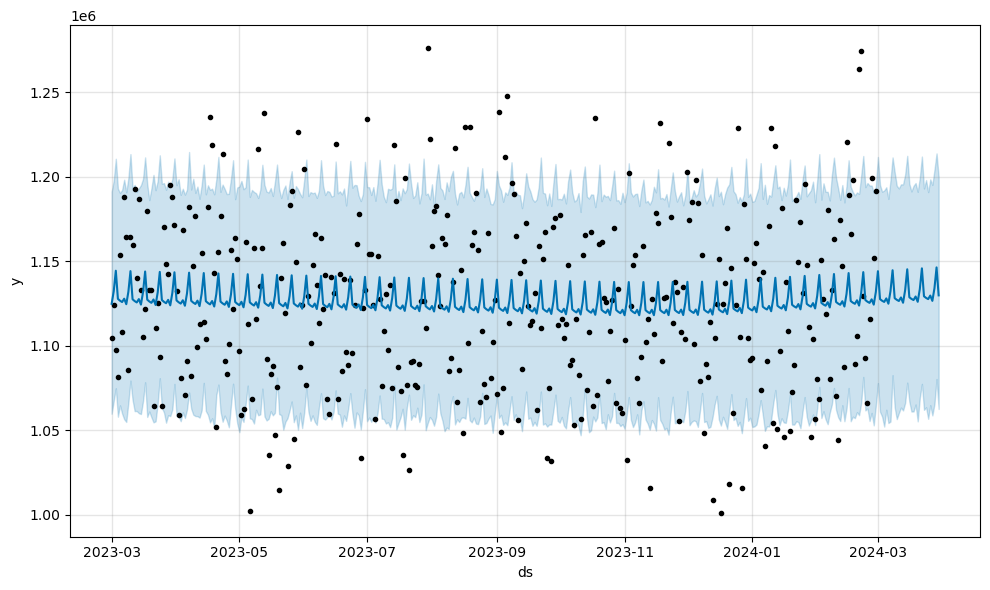

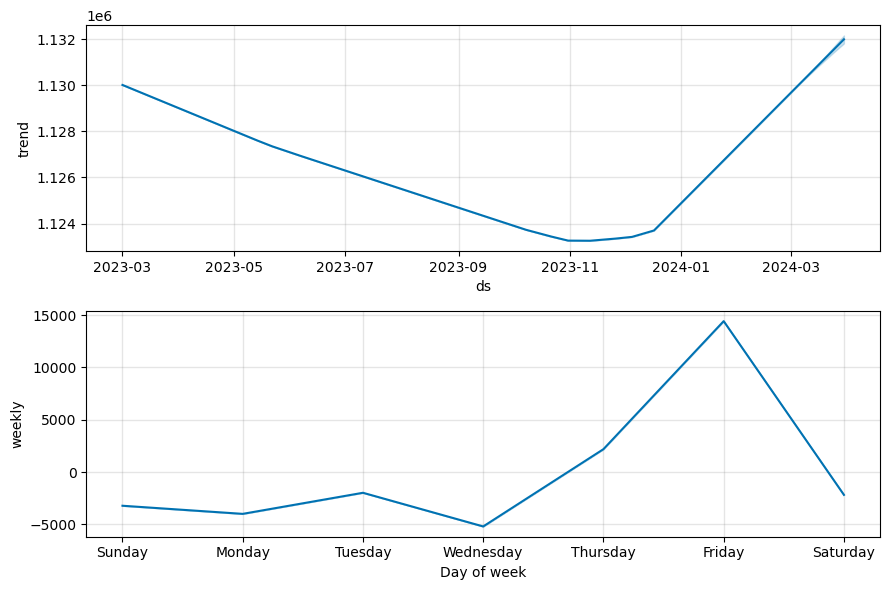

In [51]:
# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df)

# Create a dataframe to hold the predictions for the next 15 days
future = model.make_future_dataframe(periods=30)

# Predict the future values
forecast = model.predict(future)

#show tail values of df and forcast
print(df.tail(15))
print(forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail(15))

# Evaluate accuracy 
# Here we calculate MAE and RMSE for the available historical data

# Actual vs Predicted on historical data
y_true = df['y'].values
y_pred = forecast['yhat'][:-30].values  # Exclude the last 15 days (future predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Calculate Root Mean Square Error (RMSE)
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Calculate R² score
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2_Score: {r2}")

#Plot the forecast
model.plot(forecast)

model.plot_components(forecast)
plt.show()

### SARIMA

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

In [18]:
df = df.rename(columns={'ds':'Date' , 'y':'Total_Amount' })

In [19]:
df.head()

,Date,Total_Amount
0,2023-03-01,1.104406e+06
1,2023-03-02,1.123873e+06
2,2023-03-03,1.097692e+06
3,2023-03-04,1.081359e+06
4,2023-03-05,1.153814e+06


In [36]:
# Example values for (p, d, q) and (P, D, Q, m) - assuming weekly seasonality
p, d, q = 1, 0, 1
P, D, Q, m = 1, 0, 1, 7  # m = 7 for weekly seasonality

In [37]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Initialize and fit the StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['Total_Amount']])
test_scaled = scaler.transform(test[['Total_Amount']])


In [38]:
# Fit the SARIMA model on the scaled training data
model = SARIMAX(train_scaled, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False)


In [39]:
# Forecast on the scaled test set
forecast_scaled = model_fit.forecast(steps=len(test_scaled))
forecast_series_scaled = pd.Series(forecast_scaled, index=test.index)

# Inverse transform the forecasted data
forecast_series = scaler.inverse_transform(forecast_series_scaled.values.reshape(-1, 1))
forecast_series = pd.Series(forecast_series.flatten(), index=test.index)


In [40]:
# Calculate accuracy metrics
mae = mean_absolute_error(test['Total_Amount'], forecast_series)
mse = mean_squared_error(test['Total_Amount'], forecast_series)
rmse = np.sqrt(mse)
r2 = r2_score(test['Total_Amount'], forecast_series)

# Print accuracy metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R^2 Score:', r2)


Mean Absolute Error (MAE): 47489.470774311114
Mean Squared Error (MSE): 3287427420.7320914
Root Mean Squared Error (RMSE): 57336.091781111936
R^2 Score: -0.005146133747294224


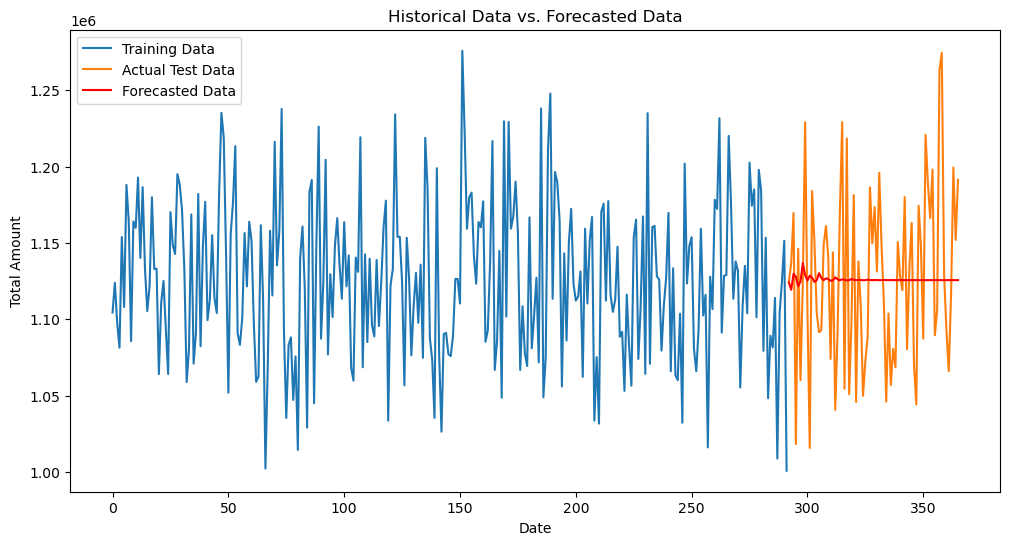

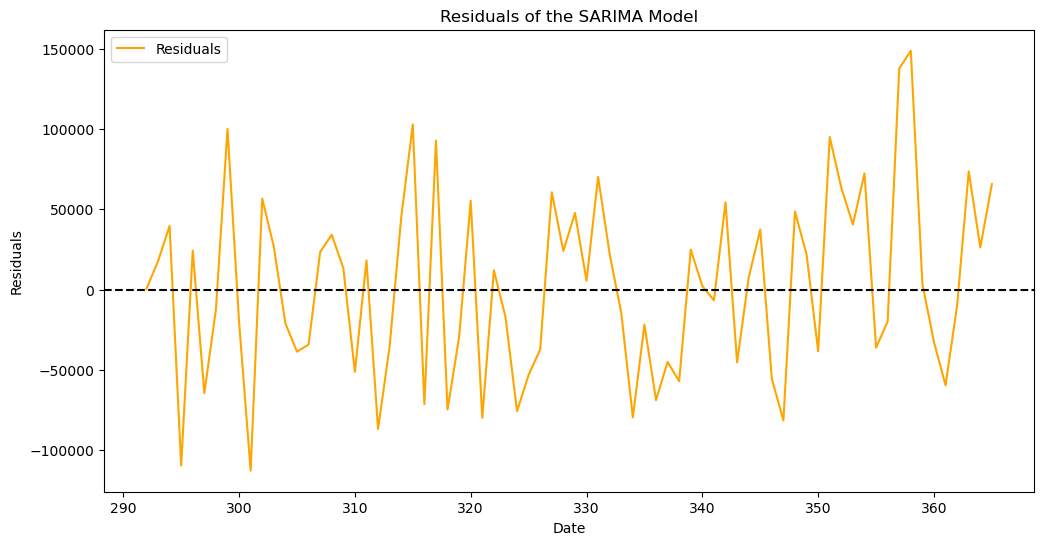

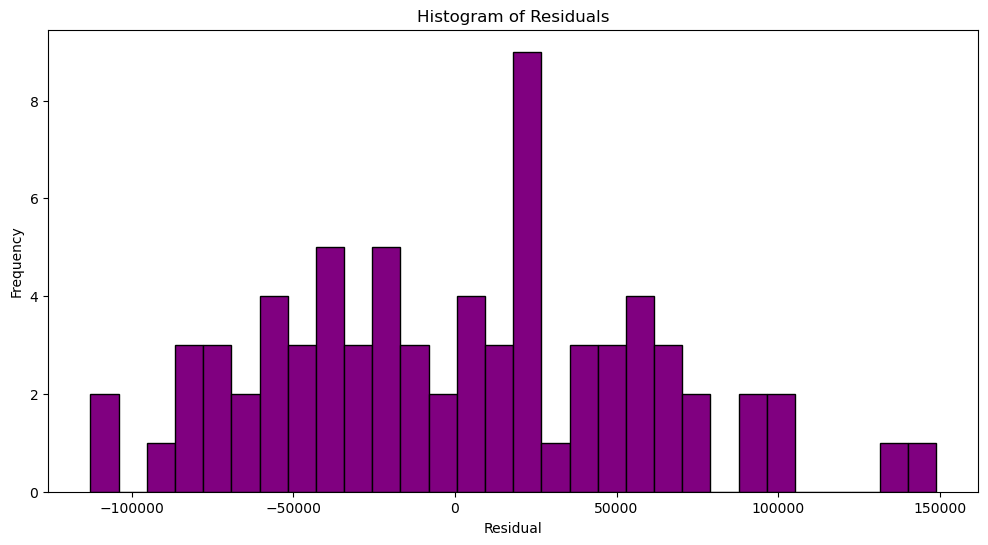

In [41]:
# Plot Historical Data vs. Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total_Amount'], label='Training Data')
plt.plot(test.index, test['Total_Amount'], label='Actual Test Data')
plt.plot(forecast_series.index, forecast_series, label='Forecasted Data', color='red')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Historical Data vs. Forecasted Data')
plt.legend()
plt.show()

# Plot Residuals
residuals = test['Total_Amount'] - forecast_series

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of the SARIMA Model')
plt.legend()
plt.show()

# Optional: Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


### LSTM

Epoch 1/100


C:\Users\Sanket\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0741
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0376
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0430
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0343
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0339
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0351
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0336
Epoch 8/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0351
Epoch 9/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0359
Epoch 10/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0325
Epoch 11/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0421
Epoch 12/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0329
Epoch 13/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0323
Epoch 14/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0361
Epoch 15/100
281/281 ━━━━━━━━━━━━━━━━━━━

281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0329
Epoch 80/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0342
Epoch 81/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0308
Epoch 82/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0305
Epoch 83/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0270
Epoch 84/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0305
Epoch 85/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0291
Epoch 86/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0295
Epoch 87/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0296
Epoch 88/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0320
Epoch 89/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0311
Epoch 90/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0320
Epoch 91/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0270
Epoch 92/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0302
Epoch 93/100
281/281 ━━━━━━━━━━━━

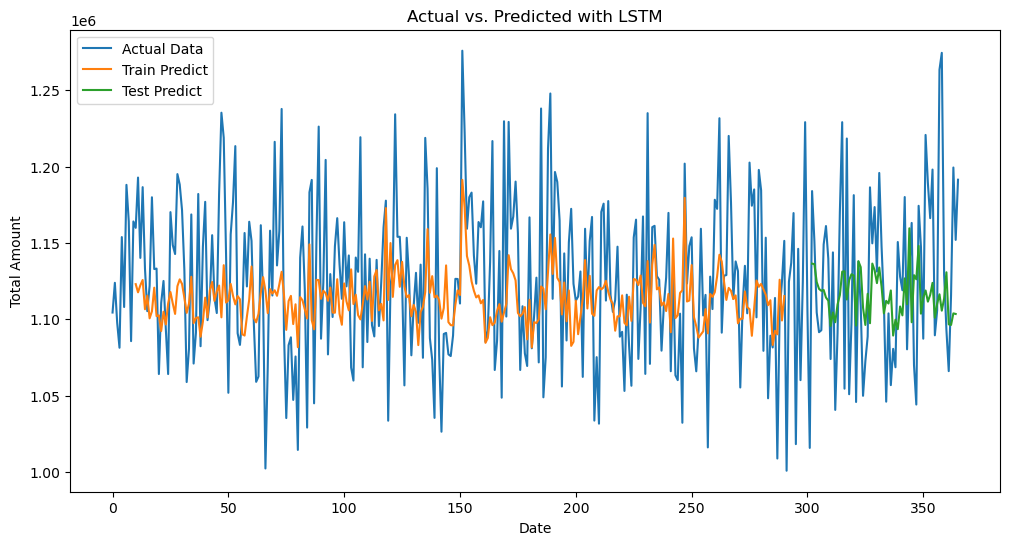

In [48]:
# import numpy as np
# import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
# import matplotlib.pyplot as plt

# # Step 1: Prepare the Data
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Total_Amount']])

# Define the time step
time_step = 10

# Create training and test datasets
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[0:train_size, :], df_scaled[train_size:len(df_scaled), :]

# Create the datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 2: Build the LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.2))  
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model
model.fit(X_train, y_train, batch_size=1, epochs=100)

# Step 4: Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Step 5: Evaluate the Model
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict))

# Calculate R^2 score
train_r2 = r2_score(y_train[0], train_predict)
test_r2 = r2_score(y_test[0], test_predict)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R^2 Score: {train_r2}')
print(f'Test R^2 Score: {test_r2}')

# Step 6: Plot the Results
train_plot = np.empty_like(df_scaled)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(df_scaled)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(df_scaled) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_scaled), label='Actual Data')
plt.plot(train_plot, label='Train Predict')
plt.plot(test_plot, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Actual vs. Predicted with LSTM')
plt.legend()
plt.show()
